<a href="https://colab.research.google.com/github/sammiyo/Time-series-analysis/blob/main/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [ ]:
df=pd.read_csv('household_power_consumption.txt', delimiter=';')

In [ ]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


In [ ]:
df.shape

(668468, 9)

In [ ]:
type(df['Global_active_power'][0])

str

In [ ]:
# df=df.dropna

**Preprocess**

In [ ]:
# combine date and time column together
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
# make Global_active_power from string to numeric
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')


In [ ]:
# create columns for year, quarter, month and day
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)

In [ ]:
df=df.loc[:,['date_time','Global_active_power', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df=df.dropna()
df = df.reset_index(drop=True)
# create weekday column to mark days from 0 to 6
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
# arrange weekday so that weekdays are 0 and weekends are 1
df["weekday"] = (df["weekday"] < 5).astype(int)

In [ ]:
df['date_time'].min()

Timestamp('2006-12-16 17:24:00')

In [ ]:
df['date_time'].max()

Timestamp('2008-12-03 23:59:00')

In [ ]:
df.shape

(664527, 7)

In [ ]:
# use D’Agostino’s K² Test to quantify whether our data looks as though it was drawn from a Gaussian distribution
stat, p = stats.normaltest(df.Global_active_power)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')


Statistics=209433.435, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: 3.3000455724441435
Skewness of normal distribution: 1.6706737339542492


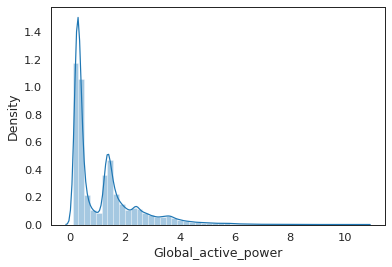

In [ ]:
# check using Kurtosis and Skewness, to determine if the data distribution departs from the normal distribution.
sns.distplot(df.Global_active_power);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Global_active_power)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Global_active_power)))

Kurtosis: describes heaviness of the tails of a distribution
Normal Distribution has a kurtosis of close to 0. If the kurtosis is greater than zero, then distribution has heavier tails. If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is greater than zero.
Skewness: measures asymmetry of the distribution
If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater than 1.

**Plot**

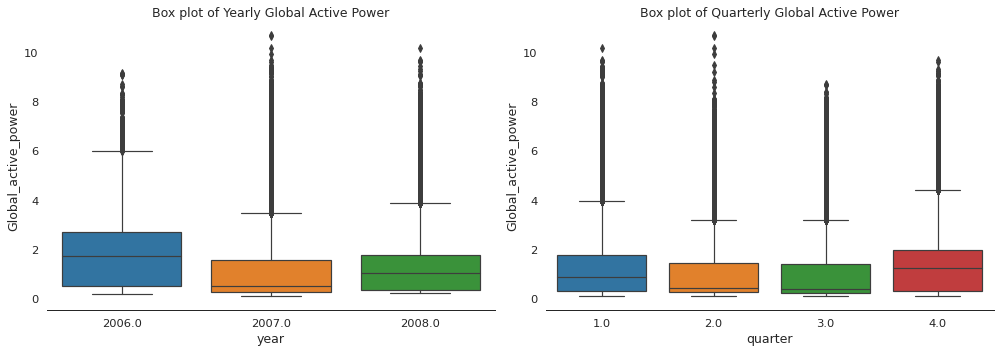

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Global_active_power", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Global Active Power')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Global_active_power", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Global Active Power')
sns.despine(left=True)
plt.tight_layout()

In [ ]:
df1=df.loc[:,['date_time','Global_active_power']]
df1.set_index('date_time',inplace=True)

,count,mean,std,min,25%,50%,75%,max
Global_active_power,664527.0000,1.1761,1.1840,0.0820,0.2940,0.6060,1.6240,10.6700


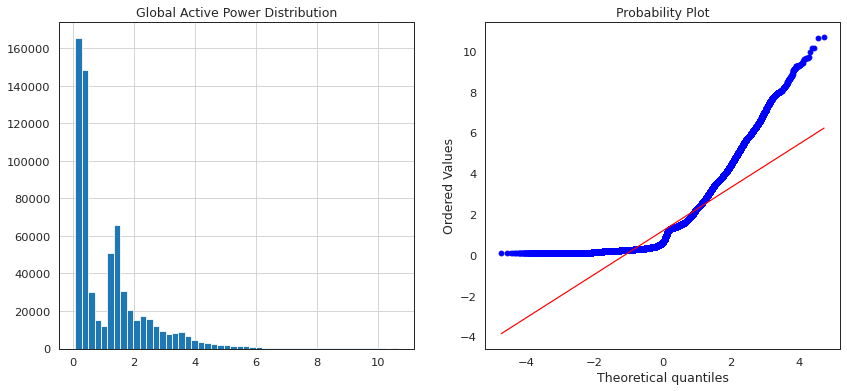

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Global_active_power'].hist(bins=50)
plt.title('Global Active Power Distribution')
plt.subplot(1,2,2)
stats.probplot(df['Global_active_power'], plot=plt)
df1.describe().T

Text(0.5, 1.0, 'Mean Global active power by Year')

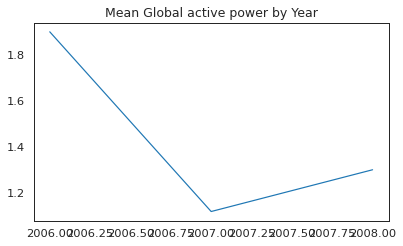

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Year')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe9249aa58>,
      dtype=object)

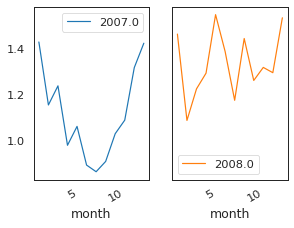

In [ ]:
pd.pivot_table(df.loc[df['year'] != 2006], values = "Global_active_power", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True)

**Dickey Fuller test for stationarity**

Stationary series has constant mean and variance over time. Rolling average and the rolling standard deviation of time series do not change over time.

Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [ ]:
df2=df1.resample('D').agg(np.mean)

In [ ]:
df1.head()

,Global_active_power
date_time,
2006-12-16 17:24:00,4.2160
2006-12-16 17:25:00,5.3600
2006-12-16 17:26:00,5.3740
2006-12-16 17:27:00,5.3880
2006-12-16 17:28:00,3.6660


In [ ]:
df2.head()

,Global_active_power
date_time,
2006-12-16,3.0535
2006-12-17,2.3545
2006-12-18,1.5304
2006-12-19,1.1571
2006-12-20,1.5457


In [ ]:
def test_stationarity(timeseries):
    # rolmean = timeseries.rolling(window=30).mean()
    # rolstd = timeseries.rolling(window=30).std()
    
    # plt.figure(figsize=(14,5))
    # sns.despine(left=True)
    # orig = plt.plot(timeseries, color='blue',label='Original')
    # mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    # std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    # plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    # plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.Global_active_power.dropna())

<Results of Dickey-Fuller Test>
Test Statistic                 -4.5964
p-value                         0.0001
#Lags Used                      9.0000
Number of Observations Used   454.0000
Critical Value (1%)            -3.4448
Critical Value (5%)            -2.8679
Critical Value (10%)           -2.5702
dtype: float64


In [ ]:
# In statistics, a unit root test tests whether a time series variable is non-stationary 
# and possesses a unit root. The null hypothesis is generally defined as the presence of a unit root 
# and the alternative hypothesis is stationarity

Running the example prints the test statistic value of -8. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -4 is less than the value of -3.4 at 1%.

This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

**LSTM Model**

In [ ]:
dataset = df.Global_active_power.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# test[0][1]


In [ ]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [ ]:
Y_train[0]

0.24914998

In [ ]:
X_train[0]

array([0.390442  , 0.49848884, 0.4998111 , 0.5011333 , 0.3384964 ,
       0.3247072 , 0.34189647, 0.3417076 , 0.3386853 , 0.3381186 ,
       0.4123536 , 0.5034001 , 0.4856441 , 0.48979977, 0.37514165,
       0.3118625 , 0.30109558, 0.31620702, 0.3007178 , 0.3443521 ,
       0.5489233 , 0.7200604 , 0.65583676, 0.48092178, 0.4148092 ,
       0.29901776, 0.2978844 , 0.29712883, 0.2999622 , 0.2924065 ],
      dtype=float32)

In [ ]:

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/20
7595/7595 [==============================] - 31s 4ms/step - loss: 0.0018 - val_loss: 6.9202e-04
Epoch 2/20
7595/7595 [==============================] - 29s 4ms/step - loss: 0.0012 - val_loss: 6.8271e-04
Epoch 3/20
7595/7595 [==============================] - 29s 4ms/step - loss: 0.0011 - val_loss: 6.7677e-04
Epoch 4/20
7595/7595 [==============================] - 28s 4ms/step - loss: 0.0011 - val_loss: 6.7025e-04
Epoch 5/20
7595/7595 [==============================] - 28s 4ms/step - loss: 0.0011 - val_loss: 6.7696e-04
Epoch 6/20
7595/7595 [==============================] - 28s 4ms/step - loss: 0.0011 - val_loss: 6.9605e-04
Epoch 7/20
7595/7595 [==============================] - 29s 4ms/step - loss: 0.0011 - val_loss: 6.8710e-04
Epoch 8/20
7595/7595 [==============================] - 28s 4ms/step - loss: 0.0011 - val_loss: 6.8142e-04
Epoch 9/20
7595/7595 [==============================] - 29s 4ms/step - loss: 0.0011 - val_loss: 7.0581e-04
Epoch 10/20
7595/7595 [==============

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.13376833623748224
Train Root Mean Squared Error: 0.3047649082560364
Test Mean Absolute Error: 0.11955690577192979
Test Root Mean Squared Error: 0.2781187052155098


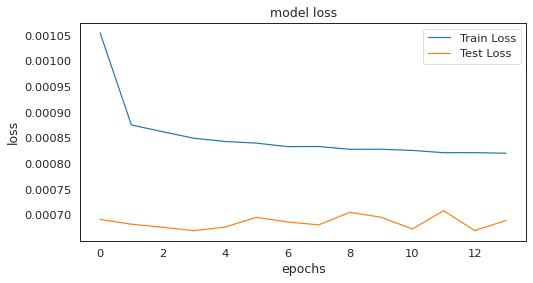

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

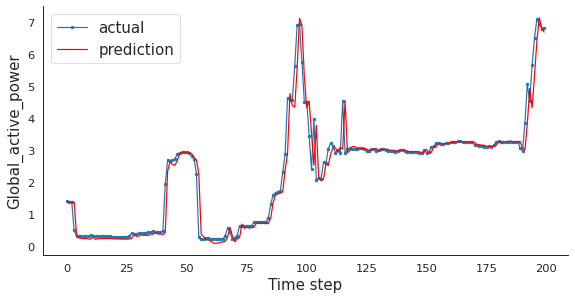

In [ ]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();